# Определение уровня шума аэродинамического профиля

## Техническое задание

Исходные данные:

1. Частота [Гц].
2. Угол атаки [град].
3. Длина хорды аэродинамического профиля [м].
4. Скорость набегающего потока [м/с].
5. Толщина аэродинамического профиля [м].

Результирующие данные:

6. Масштабированный уровень звукового давления [Дб].

Требования:

1. mae <= 10 [db] for regretion model

# Импорт библиотек

## Стандартные библиоткеуи

Python

In [1]:
import sys
import os
from tqdm import tqdm
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sklern

In [2]:
import sklearn

from sklearn.model_selection import train_test_split

print(sklearn.__version__)

1.4.1.post1


tensorflow

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, Input, Dense
from tensorflow.keras import Sequential
from tensorflow.keras import activations
from tensorflow import optimizers

print(tf.__version__)

2.16.1


## Частные библиотеки

In [4]:
sys.path.append('D:/Programming/Python')

In [5]:
from tools import export2, rounding
from decorators import timeit
from ml_tools import detect_outliers, find_drop_features, pairplot, SCALERS, Model, training_plot, predictions_plot

# Определение констант

# Импорт исходных данных

In [6]:
os.listdir()

['airfoil_self_noise.dat',
 'app.py',
 'home.html',
 'Airfoil Self-Noise - UCI Machine Learning Repository.html',
 'airfoil_noise.ipynb',
 'exports',
 'checkpoints',
 '.git',
 'log.csv',
 '.ipynb_checkpoints',
 'features.ipynb',
 'model_sklearn.pkl',
 'model_tf.keras',
 'model_airfoil_noise.pkl']

In [7]:
df = pd.read_csv("airfoil_self_noise.dat", sep="\t", header=None)
df

,0,1,2,3,4,5
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [8]:
df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1503 non-null   int64  
 1   1       1503 non-null   float64
 2   2       1503 non-null   float64
 3   3       1503 non-null   float64
 4   4       1503 non-null   float64
 5   5       1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


# Обработка исходных данных

## Предварительная обработка

In [9]:
df.columns = ["Frequency [Hz]", "Attack angle [deg]", "Chord length [m]", "Free-stream velocity [m/s]", "Thickness [m]", "Pressure level [db]"]

In [10]:
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


## Обработка типов данных

In [11]:
df.dtypes

Frequency [Hz]                  int64
Attack angle [deg]            float64
Chord length [m]              float64
Free-stream velocity [m/s]    float64
Thickness [m]                 float64
Pressure level [db]           float64
dtype: object

In [12]:
all(map(lambda tp: 'bool' in str(tp).lower() or 'int' in str(tp).lower() or 'float' in str(tp).lower(), df.dtypes))

True

## Обработка локальных пустот

In [13]:
df.isna().sum()

Frequency [Hz]                0
Attack angle [deg]            0
Chord length [m]              0
Free-stream velocity [m/s]    0
Thickness [m]                 0
Pressure level [db]           0
dtype: int64

In [14]:
if not all(df.isna().sum()): df.dropna(axis=0, inplace=True)

In [15]:
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


## Обработка сбалансированности

In [16]:
df.shape

(1503, 6)

In [17]:
pd.DataFrame(df.value_counts())

count
Frequency [Hz] Attack angle [deg] Chord length [m] Free-stream velocity [m/s] Thickness [m] Pressure level [db]       
200            0.0                0.3048           31.7                       0.003313      117.195                  1
3150           0.0                0.3048           71.3                       0.002663      125.201                  1
               3.0                0.3048           31.7                       0.005295      118.108                  1
               2.7                0.1524           71.3                       0.002439      127.054                  1
                                                   39.6                       0.002948      122.919                  1
...                                                                                                                ...
1000           3.3                0.1016           55.5                       0.002211      131.129                  1
                                                   39.6                       0.002451      131.971                  1
                                                   31.7                       0.002514      133.012                  1
               3.0                0.3048           71.3                       0.004257      129.004                  1
20000          4.8                0.0254           71.3                       0.000849      119.708                  1

[1503 rows x 1 columns]

# Анализ данных

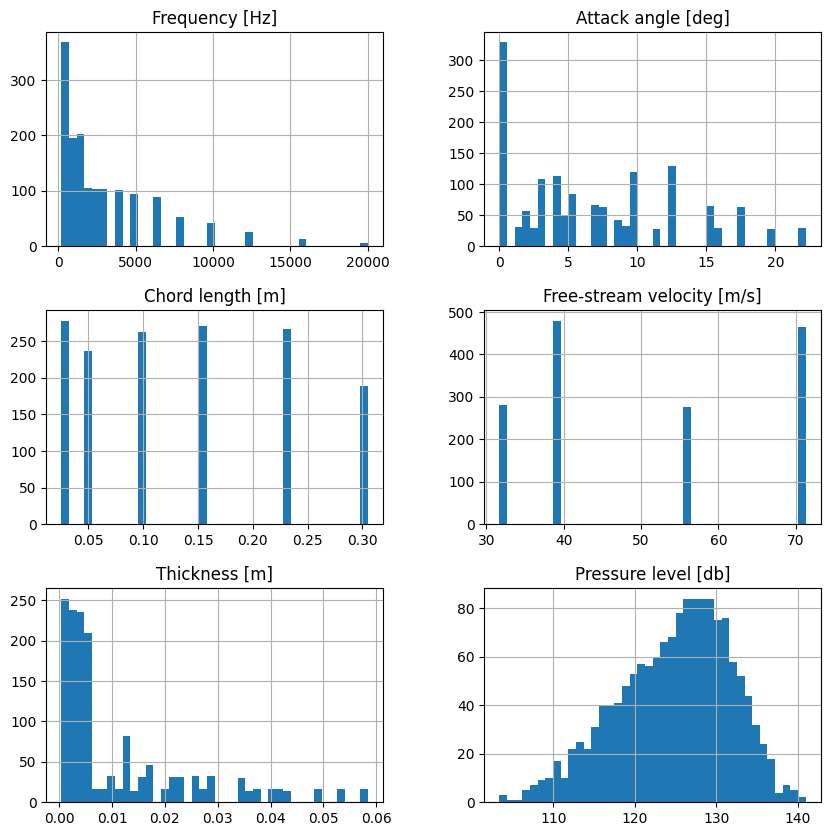

In [18]:
df.hist(figsize=(10, 10), bins=40);

In [19]:
detect_outliers(df, '3sigma')

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
12,12500,0.0,0.3048,71.3,0.002663,112.241
13,16000,0.0,0.3048,71.3,0.002663,108.721
28,12500,0.0,0.3048,55.5,0.002831,111.076
47,12500,0.0,0.3048,39.6,0.003101,109.619
78,12500,1.5,0.3048,71.3,0.003367,109.222
...,...,...,...,...,...,...
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224
1502,6300,15.6,0.1016,39.6,0.052849,104.204
723,5000,12.6,0.1524,39.6,0.058411,104.130


In [20]:
detect_outliers(df, 'Tukey')

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
11,10000,0.0,0.3048,71.3,0.002663,115.391
12,12500,0.0,0.3048,71.3,0.002663,112.241
13,16000,0.0,0.3048,71.3,0.002663,108.721
27,10000,0.0,0.3048,55.5,0.002831,113.076
28,12500,0.0,0.3048,55.5,0.002831,111.076
...,...,...,...,...,...,...
1502,6300,15.6,0.1016,39.6,0.052849,104.204
722,4000,12.6,0.1524,39.6,0.058411,104.500
723,5000,12.6,0.1524,39.6,0.058411,104.130
724,6300,12.6,0.1524,39.6,0.058411,103.380


In [21]:
#df = df.drop(detect_outliers(df, '3sigma').index)

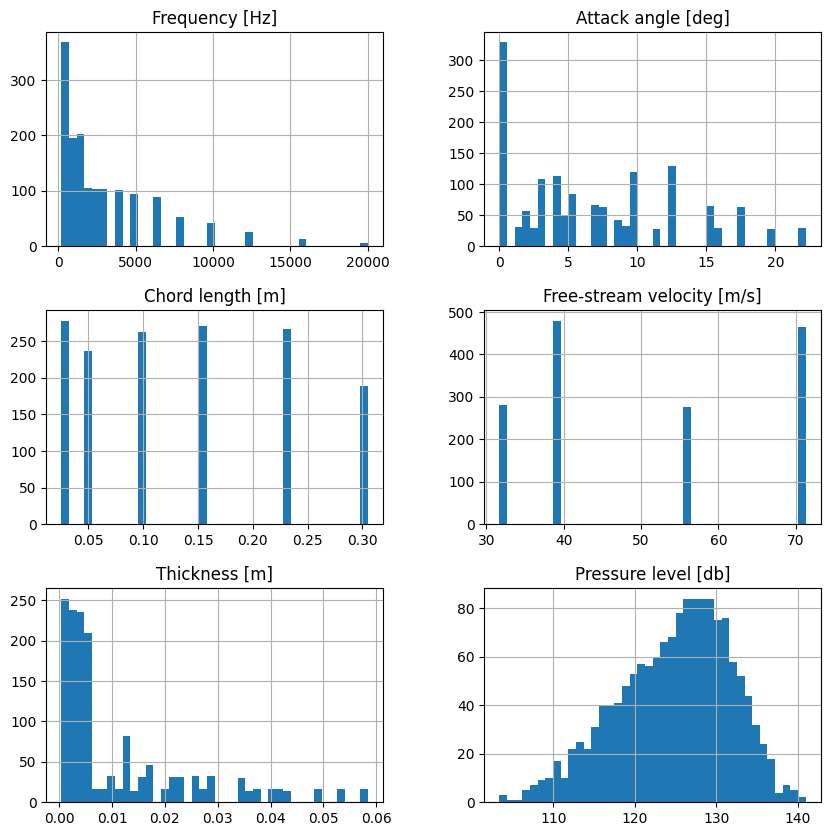

In [22]:
df.hist(figsize=(10, 10), bins=40);

In [23]:
'''for i in range(len(data.columns)-1):
    sns.jointplot(x=data.columns[i], y=data.columns[-1], data=data(), kind='reg')
    plt.show()'''

"for i in range(len(data.columns)-1):\n    sns.jointplot(x=data.columns[i], y=data.columns[-1], data=data(), kind='reg')\n    plt.show()"

In [24]:
'''for i in range(len(data.columns)-1):
    sns.jointplot(x=data.columns[i], y=data.columns[-1], data=data(), kind='kde')
    plt.show()'''

"for i in range(len(data.columns)-1):\n    sns.jointplot(x=data.columns[i], y=data.columns[-1], data=data(), kind='kde')\n    plt.show()"

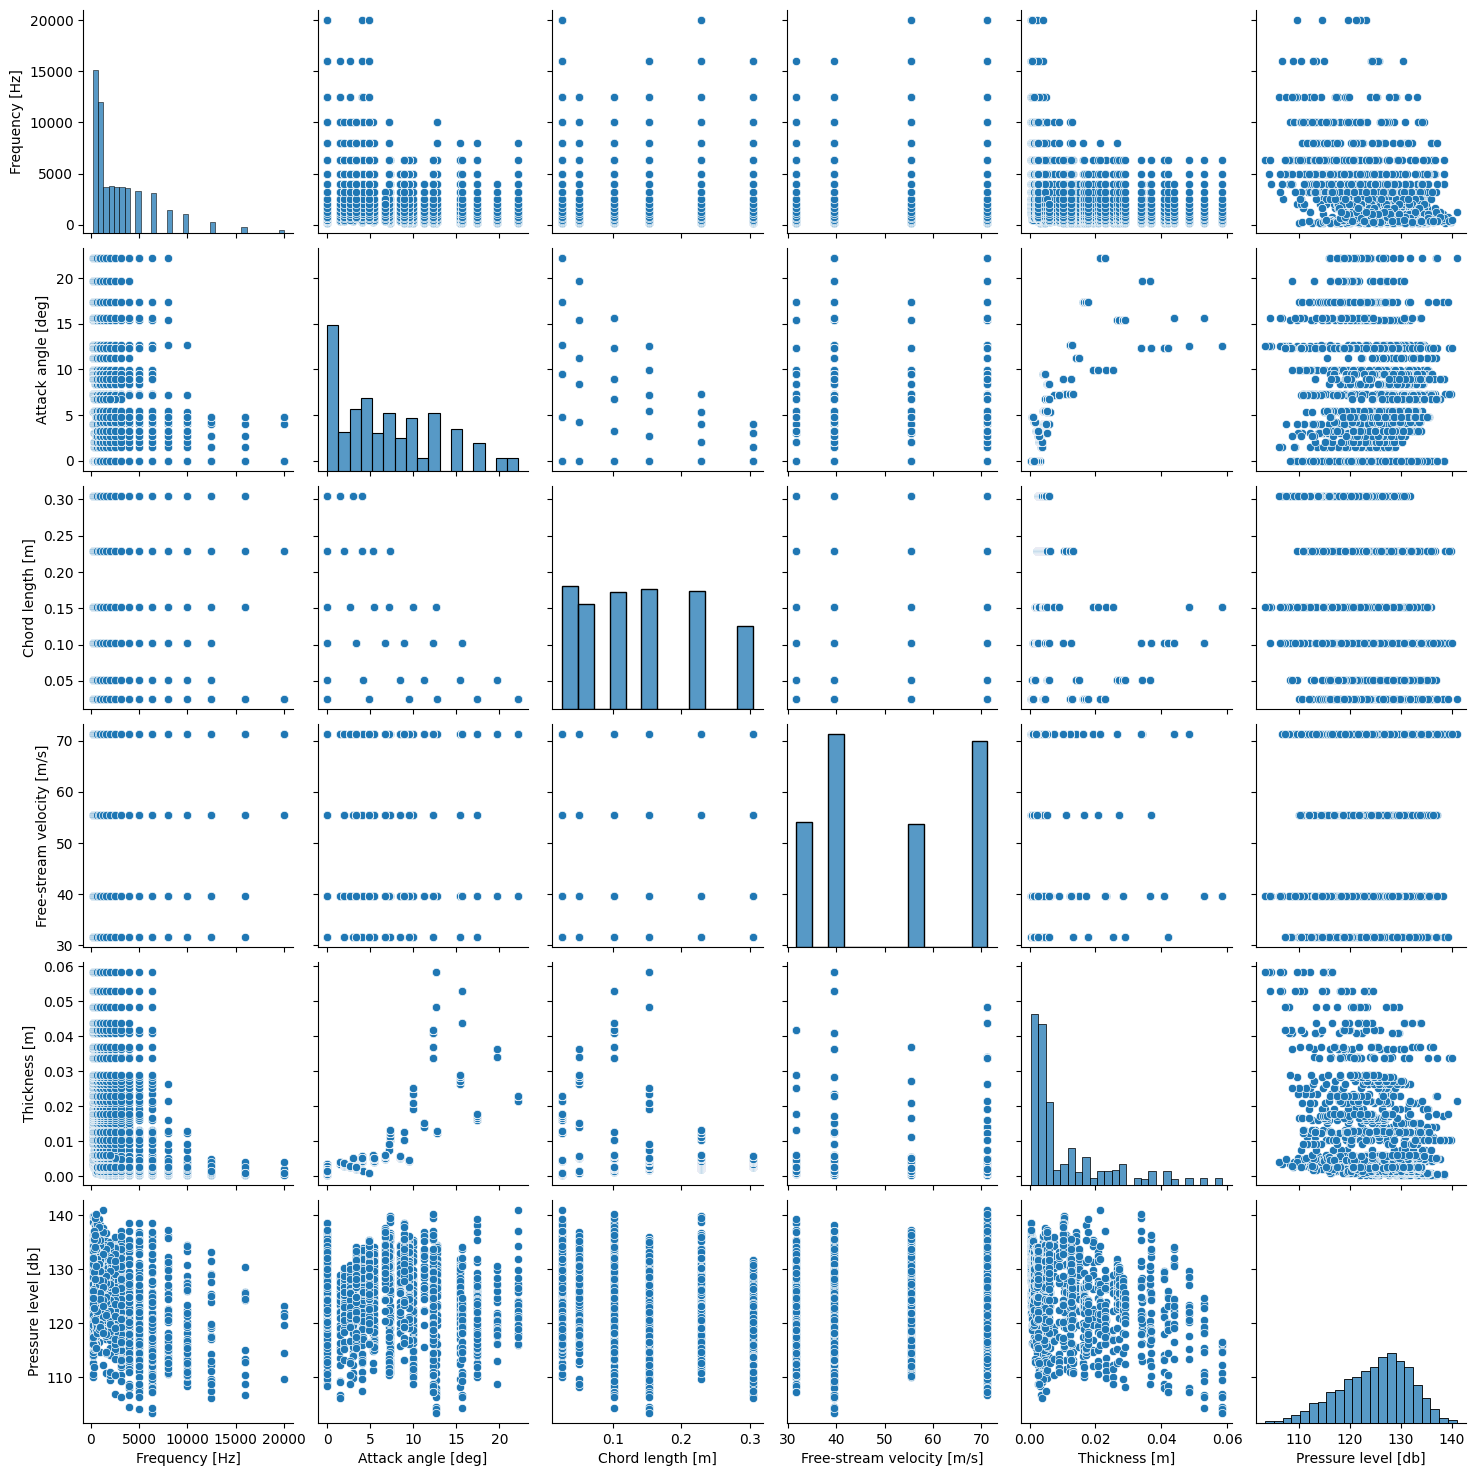

In [25]:
sns.pairplot(df);

In [26]:
'''pairplot(df, figsize=(15, 15), savefig=True)'''

'pairplot(df, figsize=(15, 15), savefig=True)'

# Корреляция данных

In [27]:
corr = df.corr()

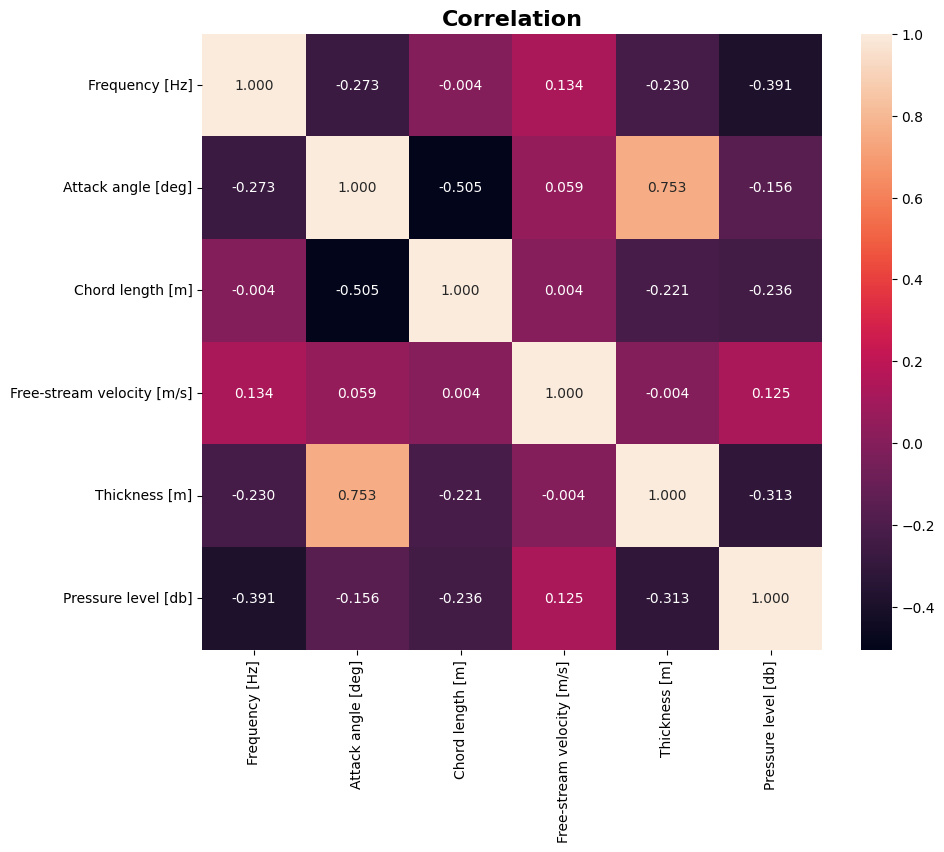

In [28]:
plt.figure(figsize=(10, 8))
plt.title('Correlation', fontsize=16, fontweight='bold')
sns.heatmap(corr, annot=True, fmt='.3f');

In [29]:
drop_features = find_drop_features(corr, threshold=0.85)
print(f'Линейно зависимые признаки: {drop_features}')

Линейно зависимые признаки: []


In [30]:
df.drop(drop_features, inplace=True)
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


## Анализ необходимости нормализации и скалирования

In [31]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Frequency [Hz],1503.0,2886.380572,3152.573137,200.000000,800.000000,1600.000000,4000.000000,20000.000000
Attack angle [deg],1503.0,6.782302,5.918128,0.000000,2.000000,5.400000,9.900000,22.200000
Chord length [m],1503.0,0.136548,0.093541,0.025400,0.050800,0.101600,0.228600,0.304800
Free-stream velocity [m/s],1503.0,50.860745,15.572784,31.700000,39.600000,39.600000,71.300000,71.300000
Thickness [m],1503.0,0.011140,0.013150,0.000401,0.002535,0.004957,0.015576,0.058411
Pressure level [db],1503.0,124.835943,6.898657,103.380000,120.191000,125.721000,129.995500,140.987000


In [32]:
scaler = SCALERS[1]()
scaler

StandardScaler()

In [33]:
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [34]:
pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,-0.662023,-1.146403,1.799299,1.312935,-0.644805,0.197939
1,-0.598561,-1.146403,1.799299,1.312935,-0.644805,0.052935
2,-0.519235,-1.146403,1.799299,1.312935,-0.644805,0.161688
3,-0.408177,-1.146403,1.799299,1.312935,-0.644805,0.399494
4,-0.281255,-1.146403,1.799299,1.312935,-0.644805,0.380644
...,...,...,...,...,...,...
1498,-0.122601,1.490443,-0.373740,-0.723345,3.172773,-2.112990
1499,0.083648,1.490443,-0.373740,-0.723345,3.172773,-2.259444
1500,0.353359,1.490443,-0.373740,-0.723345,3.172773,-2.643705
1501,0.670666,1.490443,-0.373740,-0.723345,3.172773,-2.698806


# Разделение данных для обучения и тестирования

In [35]:
test_size = 0.2
shuffle = True
random_state = 0

In [36]:
train_df, test_df = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=random_state)

In [37]:
train_df.shape, test_df.shape

((1202, 6), (301, 6))

# Разделение данных на признаки и целевую функцию

In [38]:
target = 'Pressure level [db]'

In [39]:
train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop(target)
test_labels = test_features.pop(target)

In [40]:
pd.concat([train_features, train_labels], axis=1)

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
1058,800,9.5,0.0254,71.3,0.004207,127.206
408,315,7.3,0.2286,55.5,0.011171,136.284
703,2000,12.6,0.1524,71.3,0.048316,117.504
1279,8000,0.0,0.1016,39.6,0.001463,122.341
140,6300,3.0,0.3048,39.6,0.004957,114.042
...,...,...,...,...,...,...
763,12500,0.0,0.0508,39.6,0.000792,123.988
835,1250,8.4,0.0508,31.7,0.005808,130.156
1216,1250,22.2,0.0254,71.3,0.021418,140.987
559,1250,5.4,0.1524,55.5,0.004333,130.777


# Классическое ML

## Поиск лучшей модели

Определение объекта модели

In [41]:
model = Model(None)

In [42]:
models = model.fit_all(train_features, train_labels, exceptions=False)

100%|██████████| 43/43 [00:01<00:00, 32.21it/s] 


In [43]:
warnings.filterwarnings('ignore')

errors, scores = dict(), dict()

for model in tqdm(models):
    predictions = model.predict(test_features)

    errors[str(model)] = model.errors(test_labels, predictions, exceptions=False)
    scores[str(model)] = model.scores(test_labels, predictions, exceptions=False)
    
warnings.filterwarnings('default')

100%|██████████| 26/26 [00:00<00:00, 35.54it/s]


In [44]:
errors = pd.DataFrame(errors)
errors

,SGDOneClassSVM(),LinearRegression(),Ridge(),Lasso(),ElasticNet(),Lars(),LassoLars(),OrthogonalMatchingPursuit(),BayesianRidge(),ARDRegression(),...,QuantileRegressor(),TheilSenRegressor(),RandomForestRegressor(),ExtraTreesRegressor(),BaggingRegressor(),GradientBoostingRegressor(),AdaBoostRegressor(),HistGradientBoostingRegressor(),DecisionTreeRegressor(),ExtraTreeRegressor()
mean_absolute_error,123.802246,3.545248,3.691568,4.455010,4.454955,3.545248,4.455010,4.775870,3.551563,4.934883,...,4.784956,3.581041,1.241807,1.073568,1.367139,1.938778,3.182451,1.221394,1.636123,2.037631
mean_squared_error,15374.035087,20.765101,22.319791,32.184320,32.086592,20.765101,32.184320,39.243295,20.793224,36.923887,...,40.029213,23.768301,3.048658,2.384637,3.777335,6.866024,15.930922,3.155005,5.159551,8.161031
root_mean_squared_error,123.992077,4.556874,4.724383,5.673123,5.664503,4.556874,5.673123,6.264447,4.559959,6.076503,...,6.326864,4.875274,1.746041,1.544227,1.943537,2.620310,3.991356,1.776233,2.271464,2.856752
max_error,137.758000,15.344562,14.958278,16.823379,16.818112,15.344562,16.823381,19.395758,15.234636,16.863000,...,18.913384,18.662566,9.038180,7.840280,9.945500,10.790129,10.653253,9.351129,13.590000,13.590000
mean_absolute_percentage_error,0.991962,0.028530,0.029844,0.036146,0.036139,0.028530,0.036146,0.038925,0.028589,0.040157,...,0.038962,0.028733,0.010025,0.008680,0.011038,0.015564,0.025852,0.009853,0.013213,0.016411
median_absolute_error,124.951000,2.758977,3.058168,3.575059,3.591656,2.758977,3.575061,3.788477,2.789413,4.043117,...,3.675391,2.829221,0.900180,0.793220,1.004300,1.443202,2.611130,0.844990,1.338000,1.510000
mean_squared_log_error,17.142996,0.001321,0.001445,0.002108,0.002101,0.001321,0.002108,0.002584,0.001324,0.002424,...,0.002645,0.001541,0.000194,0.000153,0.000239,0.000431,0.001036,0.000199,0.000326,0.000510
root_mean_squared_log_error,4.140410,0.036350,0.038013,0.045912,0.045833,0.036350,0.045912,0.050833,0.036393,0.049235,...,0.051432,0.039253,0.013924,0.012349,0.015465,0.020754,0.032186,0.014109,0.018065,0.022576


In [45]:
scores = pd.DataFrame(scores)
scores

,SGDOneClassSVM(),LinearRegression(),Ridge(),Lasso(),ElasticNet(),Lars(),LassoLars(),OrthogonalMatchingPursuit(),BayesianRidge(),ARDRegression(),...,QuantileRegressor(),TheilSenRegressor(),RandomForestRegressor(),ExtraTreesRegressor(),BaggingRegressor(),GradientBoostingRegressor(),AdaBoostRegressor(),HistGradientBoostingRegressor(),DecisionTreeRegressor(),ExtraTreeRegressor()
r2_score,-325.835857,0.558556,0.525505,3.157951e-01,3.178727e-01,0.558556,3.157951e-01,1.657287e-01,0.557958,2.150369e-01,...,1.490209e-01,0.494711,0.935189,0.949305,9.196978e-01,8.540355e-01,6.613253e-01,0.932928,8.903134e-01,8.265050e-01
d2_absolute_error_score,-22.204658,0.335503,0.308077,1.649829e-01,1.649933e-01,0.335503,1.649830e-01,1.048432e-01,0.334319,7.503885e-02,...,1.031402e-01,0.328794,0.767244,0.798778,7.437527e-01,6.366085e-01,4.035028e-01,0.771070,6.933362e-01,6.180801e-01
rand_score,0.000000,1.000000,1.000000,9.992248e-01,9.992248e-01,1.000000,9.992248e-01,9.453378e-01,1.000000,9.901883e-01,...,9.859136e-01,1.000000,1.000000,1.000000,9.999779e-01,9.998893e-01,9.852713e-01,1.000000,9.988926e-01,9.989369e-01
adjusted_rand_score,0.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,...,0.000000e+00,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00
completeness_score,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,...,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
homogeneity_score,0.000000,1.000000,1.000000,9.743739e-01,9.743739e-01,1.000000,9.743739e-01,5.116095e-01,1.000000,7.782914e-01,...,7.288743e-01,1.000000,1.000000,1.000000,9.991930e-01,9.959650e-01,7.661705e-01,1.000000,9.626645e-01,9.666592e-01
v_measure_score,0.000000,1.000000,1.000000,9.870206e-01,9.870206e-01,1.000000,9.870206e-01,6.769070e-01,1.000000,8.753249e-01,...,8.431779e-01,1.000000,1.000000,1.000000,9.995963e-01,9.979784e-01,8.676065e-01,1.000000,9.809771e-01,9.830470e-01
d2_tweedie_score,-325.835857,0.558556,0.525505,3.157951e-01,3.178727e-01,0.558556,3.157951e-01,1.657287e-01,0.557958,2.150369e-01,...,1.490209e-01,0.494711,0.935189,0.949305,9.196978e-01,8.540355e-01,6.613253e-01,0.932928,8.903134e-01,8.265050e-01
d2_pinball_score,-22.204658,0.335503,0.308077,1.649829e-01,1.649933e-01,0.335503,1.649830e-01,1.048432e-01,0.334319,7.503885e-02,...,1.031402e-01,0.328794,0.767244,0.798778,7.437527e-01,6.366085e-01,4.035028e-01,0.771070,6.933362e-01,6.180801e-01
mutual_info_score,0.000000,5.707110,5.707110,5.560859e+00,5.560859e+00,5.707110,5.560859e+00,2.919812e+00,5.707110,4.441795e+00,...,4.159766e+00,5.707110,5.707110,5.707110,5.702505e+00,5.684082e+00,4.372620e+00,5.707110,5.494032e+00,5.516831e+00


In [46]:
stats = pd.concat([errors, scores], axis=0)
stats

,SGDOneClassSVM(),LinearRegression(),Ridge(),Lasso(),ElasticNet(),Lars(),LassoLars(),OrthogonalMatchingPursuit(),BayesianRidge(),ARDRegression(),...,QuantileRegressor(),TheilSenRegressor(),RandomForestRegressor(),ExtraTreesRegressor(),BaggingRegressor(),GradientBoostingRegressor(),AdaBoostRegressor(),HistGradientBoostingRegressor(),DecisionTreeRegressor(),ExtraTreeRegressor()
mean_absolute_error,123.802246,3.545248,3.691568,4.455010e+00,4.454955e+00,3.545248,4.455010e+00,4.775870e+00,3.551563,4.934883e+00,...,4.784956e+00,3.581041,1.241807,1.073568,1.367139e+00,1.938778e+00,3.182451e+00,1.221394,1.636123e+00,2.037631e+00
mean_squared_error,15374.035087,20.765101,22.319791,3.218432e+01,3.208659e+01,20.765101,3.218432e+01,3.924329e+01,20.793224,3.692389e+01,...,4.002921e+01,23.768301,3.048658,2.384637,3.777335e+00,6.866024e+00,1.593092e+01,3.155005,5.159551e+00,8.161031e+00
root_mean_squared_error,123.992077,4.556874,4.724383,5.673123e+00,5.664503e+00,4.556874,5.673123e+00,6.264447e+00,4.559959,6.076503e+00,...,6.326864e+00,4.875274,1.746041,1.544227,1.943537e+00,2.620310e+00,3.991356e+00,1.776233,2.271464e+00,2.856752e+00
max_error,137.758000,15.344562,14.958278,1.682338e+01,1.681811e+01,15.344562,1.682338e+01,1.939576e+01,15.234636,1.686300e+01,...,1.891338e+01,18.662566,9.038180,7.840280,9.945500e+00,1.079013e+01,1.065325e+01,9.351129,1.359000e+01,1.359000e+01
mean_absolute_percentage_error,0.991962,0.028530,0.029844,3.614626e-02,3.613933e-02,0.028530,3.614626e-02,3.892451e-02,0.028589,4.015658e-02,...,3.896177e-02,0.028733,0.010025,0.008680,1.103785e-02,1.556414e-02,2.585191e-02,0.009853,1.321305e-02,1.641099e-02
median_absolute_error,124.951000,2.758977,3.058168,3.575059e+00,3.591656e+00,2.758977,3.575061e+00,3.788477e+00,2.789413,4.043117e+00,...,3.675391e+00,2.829221,0.900180,0.793220,1.004300e+00,1.443202e+00,2.611130e+00,0.844990,1.338000e+00,1.510000e+00
mean_squared_log_error,17.142996,0.001321,0.001445,2.107916e-03,2.100638e-03,0.001321,2.107916e-03,2.584038e-03,0.001324,2.424084e-03,...,2.645217e-03,0.001541,0.000194,0.000153,2.391562e-04,4.307142e-04,1.035970e-03,0.000199,3.263456e-04,5.096642e-04
root_mean_squared_log_error,4.140410,0.036350,0.038013,4.591204e-02,4.583271e-02,0.036350,4.591204e-02,5.083343e-02,0.036393,4.923499e-02,...,5.143167e-02,0.039253,0.013924,0.012349,1.546467e-02,2.075366e-02,3.218649e-02,0.014109,1.806504e-02,2.257574e-02
r2_score,-325.835857,0.558556,0.525505,3.157951e-01,3.178727e-01,0.558556,3.157951e-01,1.657287e-01,0.557958,2.150369e-01,...,1.490209e-01,0.494711,0.935189,0.949305,9.196978e-01,8.540355e-01,6.613253e-01,0.932928,8.903134e-01,8.265050e-01
d2_absolute_error_score,-22.204658,0.335503,0.308077,1.649829e-01,1.649933e-01,0.335503,1.649830e-01,1.048432e-01,0.334319,7.503885e-02,...,1.031402e-01,0.328794,0.767244,0.798778,7.437527e-01,6.366085e-01,4.035028e-01,0.771070,6.933362e-01,6.180801e-01


Удаление неподходящих моделей

In [47]:
stats = stats.transpose()
stats = stats[(stats > 0).all(axis=1)]
stats = stats.transpose()
stats

,LinearRegression(),Ridge(),Lars(),BayesianRidge(),RANSACRegressor(),PoissonRegressor(),HuberRegressor(),TweedieRegressor(),TheilSenRegressor(),RandomForestRegressor(),ExtraTreesRegressor(),HistGradientBoostingRegressor()
mean_absolute_error,3.545248,3.691568,3.545248,3.551563,4.157100,3.960220,5.154495,4.446718,3.581041,1.241807,1.073568,1.221394
mean_squared_error,20.765101,22.319791,20.765101,20.793224,32.255974,25.430791,42.962856,31.879186,23.768301,3.048658,2.384637,3.155005
root_mean_squared_error,4.556874,4.724383,4.556874,4.559959,5.679434,5.042895,6.554606,5.646166,4.875274,1.746041,1.544227,1.776233
max_error,15.344562,14.958278,15.344562,15.234636,21.521286,15.494579,20.291632,16.777574,18.662566,9.038180,7.840280,9.351129
mean_absolute_percentage_error,0.028530,0.029844,0.028530,0.028589,0.033917,0.032104,0.041608,0.036066,0.028733,0.010025,0.008680,0.009853
median_absolute_error,2.758977,3.058168,2.758977,2.789413,3.064019,3.263319,4.286890,3.676287,2.829221,0.900180,0.793220,0.844990
mean_squared_log_error,0.001321,0.001445,0.001321,0.001324,0.002176,0.001660,0.002809,0.002086,0.001541,0.000194,0.000153,0.000199
root_mean_squared_log_error,0.036350,0.038013,0.036350,0.036393,0.046642,0.040740,0.052998,0.045675,0.039253,0.013924,0.012349,0.014109
r2_score,0.558556,0.525505,0.558556,0.557958,0.314272,0.459368,0.086655,0.322282,0.494711,0.935189,0.949305,0.932928
d2_absolute_error_score,0.335503,0.308077,0.335503,0.334319,0.220821,0.257723,0.033876,0.166537,0.328794,0.767244,0.798778,0.771070


In [48]:
cmap = sns.color_palette('coolwarm', as_cmap=True)
stats.style.background_gradient(cmap=cmap)

,LinearRegression(),Ridge(),Lars(),BayesianRidge(),RANSACRegressor(),PoissonRegressor(),HuberRegressor(),TweedieRegressor(),TheilSenRegressor(),RandomForestRegressor(),ExtraTreesRegressor(),HistGradientBoostingRegressor()
mean_absolute_error,3.545248,3.691568,3.545248,3.551563,4.157100,3.960220,5.154495,4.446718,3.581041,1.241807,1.073568,1.221394
mean_squared_error,20.765101,22.319791,20.765101,20.793224,32.255974,25.430791,42.962856,31.879186,23.768301,3.048658,2.384637,3.155005
root_mean_squared_error,4.556874,4.724383,4.556874,4.559959,5.679434,5.042895,6.554606,5.646166,4.875274,1.746041,1.544227,1.776233
max_error,15.344562,14.958278,15.344562,15.234636,21.521286,15.494579,20.291632,16.777574,18.662566,9.038180,7.840280,9.351129
mean_absolute_percentage_error,0.028530,0.029844,0.028530,0.028589,0.033917,0.032104,0.041608,0.036066,0.028733,0.010025,0.008680,0.009853
median_absolute_error,2.758977,3.058168,2.758977,2.789413,3.064019,3.263319,4.286890,3.676287,2.829221,0.900180,0.793220,0.844990
mean_squared_log_error,0.001321,0.001445,0.001321,0.001324,0.002176,0.001660,0.002809,0.002086,0.001541,0.000194,0.000153,0.000199
root_mean_squared_log_error,0.036350,0.038013,0.036350,0.036393,0.046642,0.040740,0.052998,0.045675,0.039253,0.013924,0.012349,0.014109
r2_score,0.558556,0.525505,0.558556,0.557958,0.314272,0.459368,0.086655,0.322282,0.494711,0.935189,0.949305,0.932928
d2_absolute_error_score,0.335503,0.308077,0.335503,0.334319,0.220821,0.257723,0.033876,0.166537,0.328794,0.767244,0.798778,0.771070


In [49]:
for i, model in enumerate(models):
    if str(model) in stats.columns:
        print(f'{i}) {model}')

1) LinearRegression()
2) Ridge()
5) Lars()
8) BayesianRidge()
11) RANSACRegressor()
13) PoissonRegressor()
14) HuberRegressor()
15) TweedieRegressor()
17) TheilSenRegressor()
18) RandomForestRegressor()
19) ExtraTreesRegressor()
23) HistGradientBoostingRegressor()


In [50]:
model = Model(models[19]())
model()

ExtraTreesRegressor()

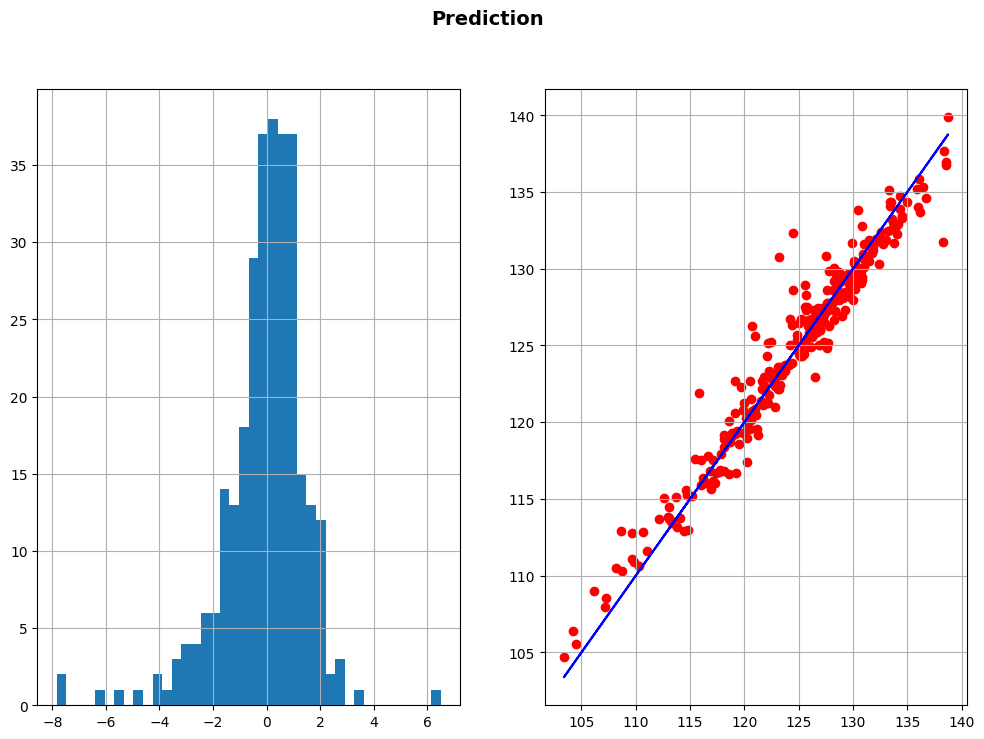

In [51]:
model.prediction(test_labels, model.predict(test_features))

## Смещение, весовые коэффициенты и уравнение

In [52]:
model.intercept

'ExtraTreesRegressor' object has no attribute 'intercept_'


In [53]:
model.coef

'ExtraTreesRegressor' object has no attribute 'coef_'


In [54]:
model.expression

'ExtraTreesRegressor' object has no attribute 'intercept_'
'ExtraTreesRegressor' object has no attribute 'coef_'
'NoneType' object is not iterable


# Экспорт модели

In [55]:
model.save('model_sklearn.pkl')
model()

D:\Programming/Python\ml_tools.py:336: ResourceWarning: unclosed file <_io.BufferedWriter name='model_sklearn.pkl'>
  pickle.dump(self.__model, open(path, 'wb'))


ExtraTreesRegressor()

# Нейронная сеть

# Определение последовательности обучения

In [56]:
normalizer = Normalization(axis=-1)
normalizer

<Normalization name=normalization, built=False>

In [57]:
normalizer.adapt(np.array(df.drop([target], axis=1)))

In [58]:
model = Sequential()

model.add(Input(shape=(len(df.columns)-1,)))
model.add(normalizer)
model.add(layers.Flatten())
#model.add(layers.Dense(units=64, activation=activations.relu, input_shape=[len(train_df.keys())]))
#model.add(layers.Dense(units=64, activation=activations.relu))
model.add(layers.Dense(units=1))

In [59]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 5)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17 (72.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 11 (48.00 B)

# Компиляция модели

tf.optimizers.

1) SGD  # Классический оптимизатор, который обновляет веса в направлении антиградиента функции потерь
2) Adam  # Оптимизатор, сочетающий в себе преимущества адаптивного градиентного спуска (Adagrad) и Root Mean Square Propagation (RMSprop).
3) RMSprop  # Оптимизатор адаптирует скорость обучения для каждого параметра на основе истории градиентов для этого параметра.
4) Adagrad  # Оптимизатор уменьшает скорость обучения для параметров, которые редко или никогда не обновлялись, и увеличивает скорость обучения для параметров, которые часто обновлялись
5) Adadelta  # Оптимизатор является расширением Adagrad и использует только последние градиенты для обновления параметров.
6) Adamax  # Оптимизатор является вариантом Adam, который использует бесконечную норму вместо L2 нормы для обновления параметров.
6) Nadam  # Оптимизатор является комбинацией методов Nesterov Accelerated Gradient (NAG) и Adam

In [60]:
learning_rate = 0.1
optimizer = optimizers.Adam(learning_rate=learning_rate)
loss = 'mae'
metrics =  ['mae', 'mse']

In [61]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

# Обучение модели

In [62]:
epochs = 100
batch_size = 32
verbose = False  # динамическое прогресс

monitor = 'loss' # что мониторить
min_delta = 0.01 # сравнивать с каким значением
patience = 5 # в течении скольких эпох

callbacks = [keras.callbacks.EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose),
             keras.callbacks.ModelCheckpoint(monitor=monitor, filepath='checkpoints/model_{epoch:d}.keras', save_best_only=True, verbose=verbose),
             keras.callbacks.CSVLogger('log.csv', separator=",", append=False),
             keras.callbacks.TerminateOnNaN()]

In [63]:
%%time
history = model.fit(
    train_features,
    train_labels,
    epochs=epochs,
    validation_data=(test_features, test_labels),
    #validation_split = 0.2,  # данные ранее не были разделены на тренировочные и тестовые
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=verbose)

CPU times: total: 4.5 s
Wall time: 3.66 s


# Анализ обучения

In [64]:
max(history.epoch)

42

"d:\Programming\projects\ML\datas\regretion\airfoil_noise/exports/training_plot.png" file exporting

"d:\Programming\projects\ML\datas\regretion\airfoil_noise/exports/training_plot.png" file has created!
"export2" elapsed 0.6388 seconds


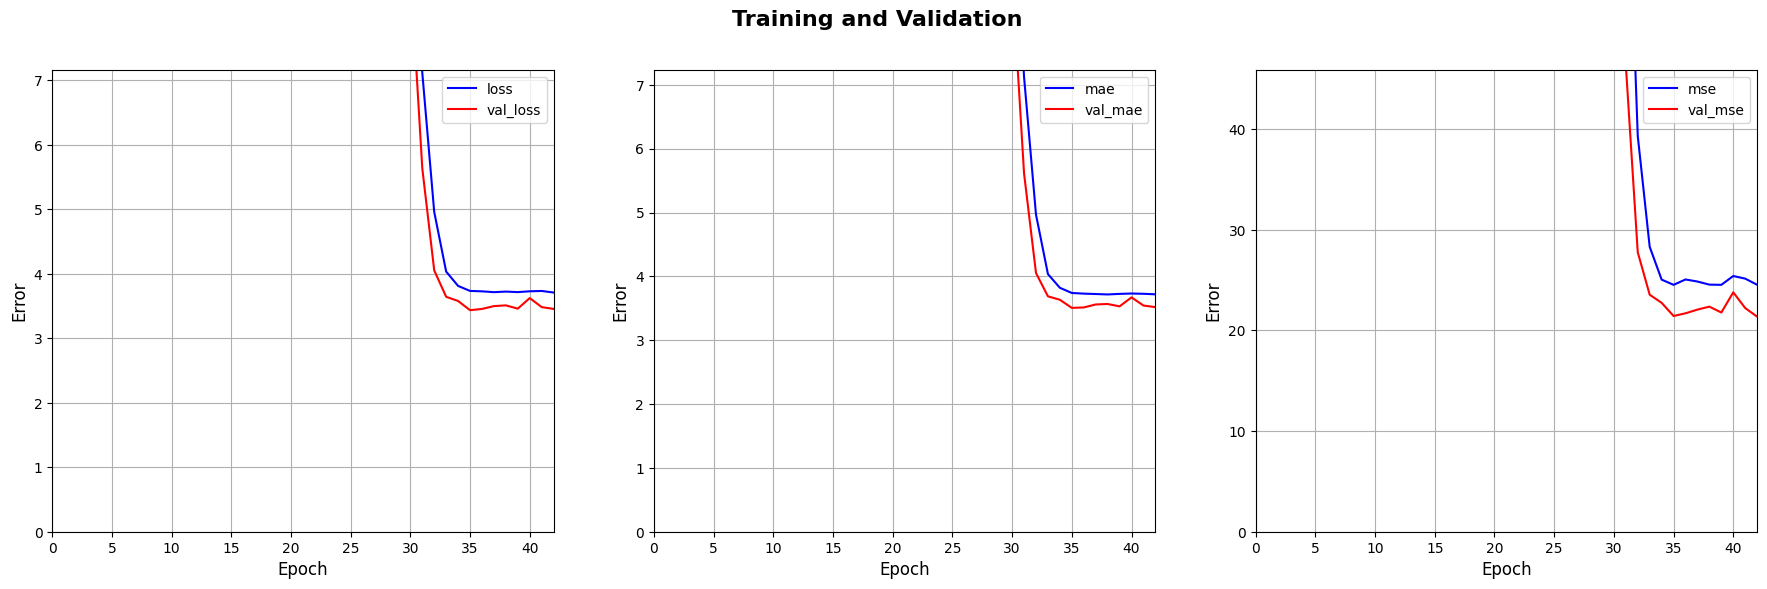

In [65]:
training_plot(history, figsize=(22, 6), savefig=True)

In [66]:
hist = pd.DataFrame(history.history)
hist.index.rename('epoch', inplace=True)
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
epoch,,,,,,
38,3.724038,3.716911,24.547935,3.510346,3.567189,22.360937
39,3.715990,3.725670,24.528034,3.459524,3.530196,21.778526
40,3.728714,3.731411,25.405659,3.623386,3.671092,23.783848
41,3.733634,3.727252,25.143372,3.483336,3.543208,22.220970
42,3.709562,3.718743,24.533924,3.455314,3.518399,21.365467


Оценка производительности модели

In [67]:
test_results = dict()
test_results['model'] = model.evaluate(test_features, test_labels, verbose=0)

In [68]:
test_results

{'model': [3.4553141593933105, 3.5183990001678467, 21.365467071533203]}

In [69]:
test_predictions = model.predict(test_features.to_numpy()).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


"d:\Programming\projects\ML\datas\regretion\airfoil_noise/exports/predictions_plot.png" file exporting

"d:\Programming\projects\ML\datas\regretion\airfoil_noise/exports/predictions_plot.png" file has created!
"export2" elapsed 0.3273 seconds


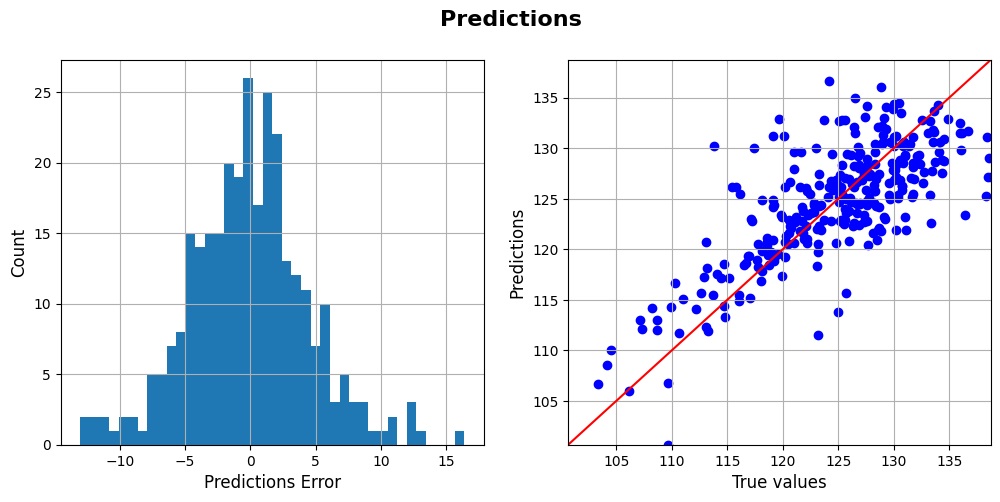

In [70]:
predictions_plot(test_labels, test_predictions, figsize=(12, 5), savefig=True)

# Экспорт модели

In [71]:
model_name = 'model_tf'
model_name += '.keras'

In [72]:
if model_name not in os.listdir(): 
    model.save(model_name)
    print('model has saved')
else:
    print('model has not saved!')

model has not saved!


In [73]:
os.path.exists(model_name)

True

In [74]:
model.save(model_name)

# Тестирование

# Импорт модели

In [75]:
os.listdir()

['airfoil_self_noise.dat',
 'app.py',
 'home.html',
 'Airfoil Self-Noise - UCI Machine Learning Repository.html',
 'airfoil_noise.ipynb',
 'exports',
 'checkpoints',
 '.git',
 'log.csv',
 '.ipynb_checkpoints',
 'features.ipynb',
 'model_sklearn.pkl',
 'model_tf.keras',
 'model_airfoil_noise.pkl']

In [76]:
model_sklearn = Model().load('model_sklearn.pkl')
model_tf = keras.models.load_model('model_tf.keras')

D:\Programming/Python\ml_tools.py:339: ResourceWarning: unclosed file <_io.BufferedReader name='model_sklearn.pkl'>
  self.__model = pickle.load(open(path, 'rb'))


## Автоматическое тестирование

In [77]:
pred_df = pd.concat([df.iloc[:, -1:],
           pd.DataFrame(model_sklearn.predict(df.iloc[:, :-1]), columns=['Predicted Pressure level [db]'])], 
           axis=1)
pred_df

,Pressure level [db],Predicted Pressure level [db]
0,126.201,126.20100
1,125.201,126.70453
2,125.951,126.65122
3,127.591,127.59100
4,127.461,127.29684
...,...,...
1498,110.264,110.26400
1499,109.254,109.25400
1500,106.604,106.60400
1501,106.224,106.22400


In [78]:
pred_df = pd.concat([df.iloc[:, -1:],
           pd.DataFrame(model_tf.predict(df.iloc[:, :-1]), columns=['Predicted Pressure level [db]'])], 
           axis=1)
pred_df

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


,Pressure level [db],Predicted Pressure level [db]
0,126.201,127.596352
1,125.201,127.302887
2,125.951,126.936058
3,127.591,126.422501
4,127.461,125.835571
...,...,...
1498,110.264,114.097450
1499,109.254,113.143692
1500,106.604,111.896469
1501,106.224,110.429146


## Ручное тестирование

In [79]:
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [80]:
airfoil_props = {"Frequency [Hz]": [800, 6300], 
                 "Attack angle [deg]": [0, 15.6], 
                 "Chord length [m]" : [0.3048, 0.1016], 
                 "Free-stream velocity [m/s]": [71.3, 39.6], 
                 "Thickness [m]": [0.002663, 0.052849]}
airfoil_props = pd.DataFrame(airfoil_props)
airfoil_props

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m]
0,800,0.0,0.3048,71.3,0.002663
1,6300,15.6,0.1016,39.6,0.052849


In [81]:
%%time
for predict in model_tf.predict(airfoil_props.to_numpy()):
    print(f'Pressure level [db]: {predict[0]} ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Pressure level [db]: 127.59642028808594 
Pressure level [db]: 108.52157592773438 
CPU times: total: 62.5 ms
Wall time: 65.8 ms


In [82]:
pd.concat([airfoil_props, pd.DataFrame(model_sklearn.predict(airfoil_props.to_numpy()), columns=['Pressure level [db]'])], axis=1)

c:\Python\Python 3.11.8\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.20100
1,6300,15.6,0.1016,39.6,0.052849,106.39368


In [83]:
pd.concat([airfoil_props, pd.DataFrame(model_tf.predict(airfoil_props.to_numpy()), columns=['Pressure level [db]'])], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,127.596420
1,6300,15.6,0.1016,39.6,0.052849,108.521576


# Экспорт лучшей модели

In [84]:
model_sklearn.save('model_airfoil_noise.pkl')

D:\Programming/Python\ml_tools.py:336: ResourceWarning: unclosed file <_io.BufferedWriter name='model_airfoil_noise.pkl'>
  pickle.dump(self.__model, open(path, 'wb'))
